In [1]:
import os
import cv2
import glob
import pydicom
import numpy as np
import matplotlib.pyplot as plt

filepath = 'data/normalHip/JOR01'
Pnr = filepath.find('JOR')
Patientnr = filepath[Pnr + len('JOR'):Pnr + len('JOR') + 2]
print('Patient Number:', Patientnr)


Patient Number: 01


In [2]:
image_files = glob.glob(os.path.join(filepath, '*.dcm'))
image_files.sort()
print('Number of Images =', len(image_files))
print('Image Files =', image_files[0])

Number of Images = 1038
Image Files = data/normalHip/JOR01/JOR01_3x_full.0001.dcm


In [3]:
Im = []
Im_Roi = []

for k in range(1, len(image_files)):  # Adjust the range according to your needs
    ds = pydicom.dcmread(image_files[k - 1])
    im = ds.pixel_array  # Load pixel data
    Im.append(im)

    # In this particular dataset, the region of interest (ROI) is defined
    im_roi = im[550:1200, 50:700]

    Im_Roi.append(im_roi)

# Convert the list of NumPy arrays to a NumPy array
Im = np.array(Im)
Im_Roi = np.array(Im_Roi)

print('Shape of the NumPy array =', Im.shape)


Shape of the NumPy array = (1037, 1536, 1536)


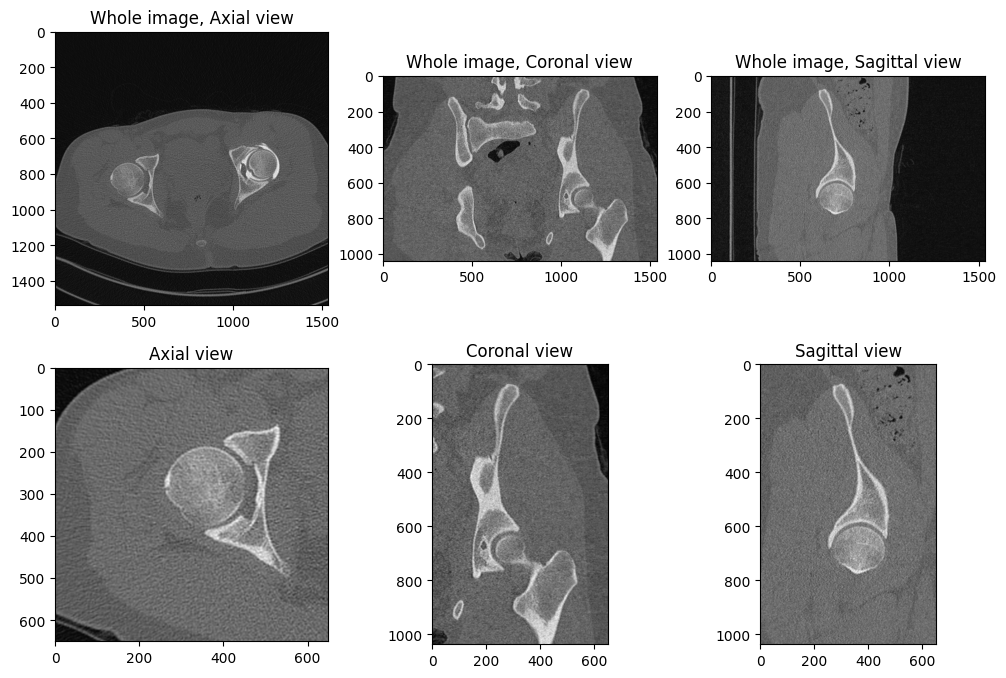

In [4]:
# Specify the slice number (sn) you want to visualize
sn = 357

# Generate the Coronal and Sagittal views
sagittal = np.rot90(np.rot90(Im[:, :, 50+sn]))
sagittal_roi = np.rot90(np.rot90(Im_Roi[:, :, sn-1]))

coronal = np.rot90(np.rot90(Im[:, 550+sn, :]))
coronal_roi = np.rot90(np.rot90(Im_Roi[:, sn - 1, :]))

axial = Im_Roi[sn - 1, :, :]

# Load the axial view image
im = pydicom.dcmread(image_files[sn - 1]).pixel_array


# Create a figure with subplots to display all views
plt.figure(figsize=(12, 8))

plt.subplot(2, 3, 1)
plt.imshow(im, cmap='gray')
plt.title('Whole image, Axial view')

plt.subplot(2, 3, 2)
plt.imshow(coronal, cmap='gray')
plt.title('Whole image, Coronal view')

plt.subplot(2, 3, 3)
plt.imshow(sagittal, cmap='gray')
plt.title('Whole image, Sagittal view')

plt.subplot(2, 3, 4)
plt.imshow(axial, cmap='gray')
plt.title('Axial view')

plt.subplot(2, 3, 5)
plt.imshow(coronal_roi, cmap='gray')
plt.title('Coronal view')

plt.subplot(2, 3, 6)
plt.imshow(sagittal_roi, cmap='gray')
plt.title('Sagittal view')

plt.show()

In [5]:
#save all images
plt.imsave('img/axial.png', im, cmap='gray')
plt.imsave('img/coronal.png', coronal, cmap='gray')
plt.imsave('img/sagittal.png', sagittal, cmap='gray')
plt.imsave('img/axial_roi.png', axial, cmap='gray')
plt.imsave('img/coronal_roi.png', coronal_roi, cmap='gray')
plt.imsave('img/sagittal_roi.png', sagittal_roi, cmap='gray')



# Locate femoral head circle

In [6]:
def treshold(image):
    #this tresholds are set to remove differet type of tissues

    #first remove the background
    _,thresh = cv2.threshold(image,230,255,cv2.THRESH_BINARY)
    
    thresh = thresh.astype(np.uint8)

    return thresh


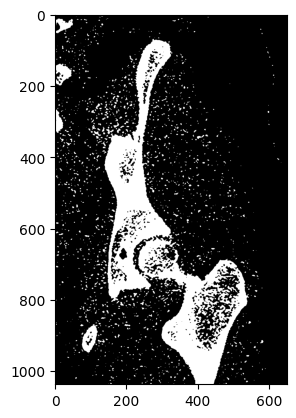

In [7]:
#test treshold  
#apply median filter to reduce noise to coronal view
preprocessed_image = cv2.GaussianBlur(coronal_roi,(3,3),0.5)
thresh = treshold(preprocessed_image)

# Normalize the image over 255 only positive
thresh = thresh - min(thresh.flatten())
thresh = thresh / max(thresh.flatten())
thresh = thresh * 255



plt.imshow(thresh, cmap='gray')
plt.show()


In [8]:
from scipy import ndimage 

def preprocess2(image, verbose=False):
    
    #apply median filter to reduce noise to coronal view
    preprocessed_image = cv2.GaussianBlur(image,(3,3),0.5)

    # Normalize the image over 255 only positive
    preprocessed_image = preprocessed_image - min(preprocessed_image.flatten())
    preprocessed_image = preprocessed_image / max(preprocessed_image.flatten())
    preprocessed_image = preprocessed_image * 255

    ret,thresh1 = cv2.threshold(preprocessed_image,124,255,cv2.THRESH_BINARY)
    thresh1 = thresh1.astype(np.uint8)

    morph = cv2.morphologyEx(thresh1, cv2.MORPH_CLOSE, np.ones((3,3)), iterations=1)

    # Perform morphological closing to fill holes
    closed = cv2.morphologyEx(morph, cv2.MORPH_ERODE, np.ones((3,3),np.uint8), iterations=1)

    dil = cv2.morphologyEx(thresh1, cv2.MORPH_DILATE, np.ones((3,3),np.uint8), iterations=1)
    fill = ndimage.binary_fill_holes(dil)
    fill = fill.astype(np.uint8)
    fill = cv2.morphologyEx(fill, cv2.MORPH_ERODE, np.ones((3,3),np.uint8), iterations=2)
    fill = fill.astype(np.uint8)

    fill = fill*255

    if verbose:
        return thresh1, morph, closed, fill
    else:
        return fill


In [45]:
def preprocess(image, verbose=False):
    #apply median filter to reduce noise to coronal view
    preprocessed_image = cv2.GaussianBlur(image,(3,3),0.5)

    # Normalize the image over 255 only positive
    preprocessed_image = preprocessed_image - min(preprocessed_image.flatten())
    preprocessed_image = preprocessed_image / max(preprocessed_image.flatten())
    preprocessed_image = preprocessed_image * 255

    ret,thresh1 = cv2.threshold(preprocessed_image,124,255,cv2.THRESH_BINARY)
    image = thresh1.astype(np.uint8)

    #apply opening
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel, iterations=2)
    
    #apply closing
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations=1)

    erode = cv2.morphologyEx(closing, cv2.MORPH_ERODE, kernel, iterations=1)

    if verbose:
        return thresh1, opening, closing, erode
    else:
        return erode


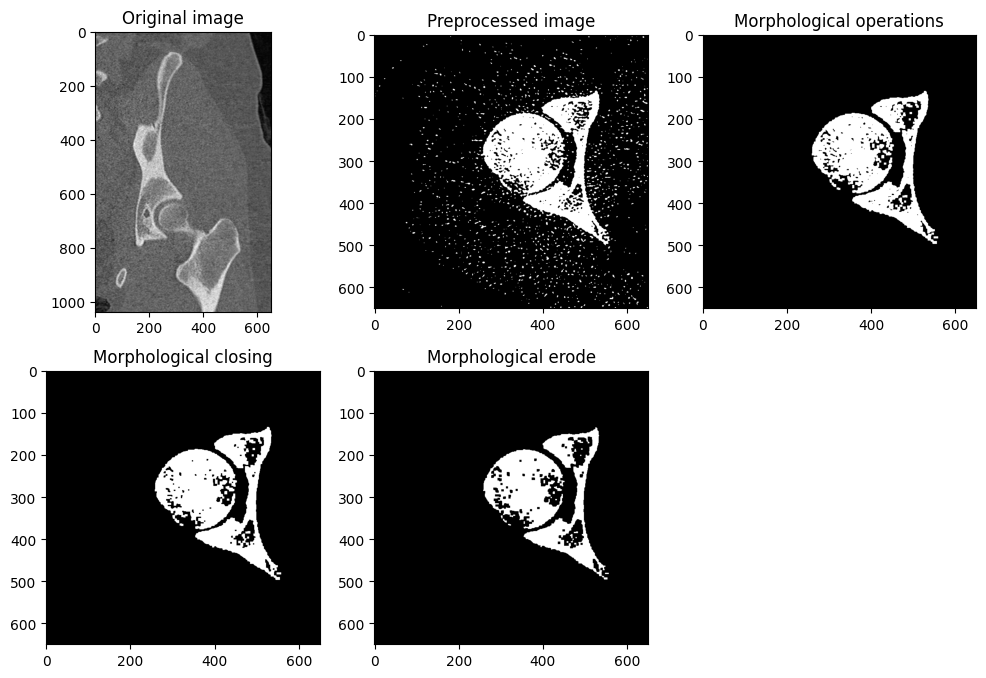

In [46]:
scan, morph, closed, erode = preprocess(axial, True)

plt.figure(figsize=(12, 8))
plt.subplot(2, 3, 1)
plt.imshow(coronal_roi, cmap='gray')
plt.title('Original image')

plt.subplot(2, 3, 2)
plt.imshow(scan, cmap='gray')
plt.title('Preprocessed image')

plt.subplot(2, 3, 3)
plt.imshow(morph, cmap='gray')
plt.title('Morphological operations')

plt.subplot(2, 3, 4)
plt.imshow(closed, cmap='gray')
plt.title('Morphological closing')

plt.subplot(2, 3, 5)
plt.imshow(erode, cmap='gray')
plt.title('Morphological erode')

plt.show()


<class 'numpy.ndarray'>


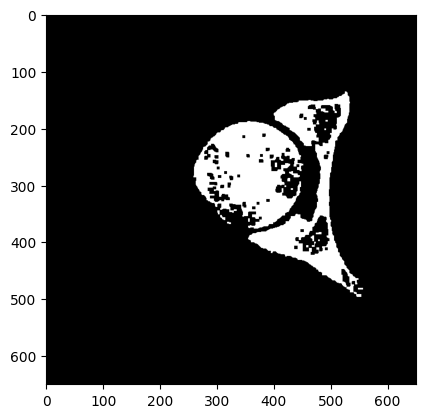

In [47]:
scan = preprocess(axial, False)
print(type(scan))
plt.imshow(scan, cmap='gray')
plt.show()


In [48]:
def find_femoral_head(img):
    scan = preprocess(img, False)

    # Detect circles using HoughCircles
    circles = cv2.HoughCircles(
        image=scan, 
        method=cv2.HOUGH_GRADIENT, 
        dp=1, 
        minDist=img.shape[1]/6,
        param1=50, 
        param2=30, 
        minRadius=30, 
        maxRadius=300
    )
    
    scan = cv2.cvtColor(scan, cv2.COLOR_GRAY2RGB)

    if circles is not None:
        circles = np.uint16(np.around(circles))
        
        for circle in circles[0, :]:
            # draw the outer circle
            cv2.circle(scan, (circle[0], circle[1]), circle[2], (255, 10,20), 4)
            # draw the center of the circle
            cv2.circle(scan, (circle[0], circle[1]), 5, (180, 0, 255), 5)
    else:
        print('No circles detected')
    
    return scan, circles

min 0
max 255
mean 27.095193234923226
type <class 'numpy.ndarray'>


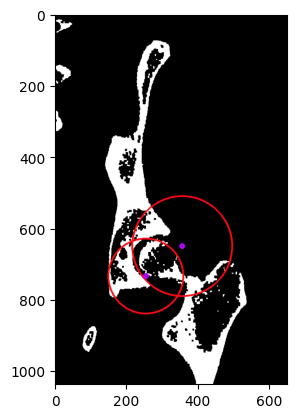

In [49]:
output , circles = find_femoral_head(coronal_roi)

#print min max  and mean of output
print('min', np.min(output))
print('max', np.max(output))
print ('mean', np.mean(output))

print('type' , type(output))


plt.imshow(output)
plt.show()

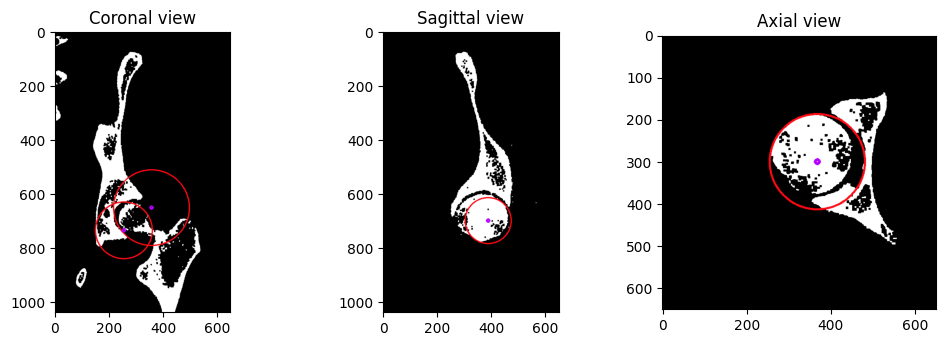

In [50]:
#test on multiple views
coronal_output , coronal_circles = find_femoral_head(coronal_roi)
sagittal_output , sagittal_circles = find_femoral_head(sagittal_roi)
axial_output , axial_circles = find_femoral_head(axial)

plt.figure(figsize=(12, 8))
plt.subplot(2, 3, 1)
plt.imshow(coronal_output, cmap='gray')
plt.title('Coronal view')

plt.subplot(2, 3, 2)
plt.imshow(sagittal_output, cmap='gray')
plt.title('Sagittal view')

plt.subplot(2, 3, 3)
plt.imshow(axial_output, cmap='gray')
plt.title('Axial view')
plt.show()
